In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

## 1. Carga de y Análisis de Datos.

In [2]:
# Carga datos entrenamiento
entrena= pd.read_csv('train_departamentos.csv', encoding='UTF-8')

In [3]:
# Carga datos prediccion.
prediccion= pd.read_csv('test_departamentos.csv', encoding='UTF-8')

In [4]:
# Inspección general datos de entrenamiento
ProfileReport(entrena)

Number of variables,12
Number of observations,25660
Total Missing (%),0.0%
Total size in memory,2.3 MiB
Average record size in memory,96.0 B
Numeric,6
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [5]:
entrena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25660 entries, 0 to 25659
Data columns (total 12 columns):
Id                        25660 non-null int64
pais                      25660 non-null object
provincia_departamento    25660 non-null object
ciudad                    25660 non-null object
property_type             25660 non-null object
operation_type            25660 non-null object
rooms                     25660 non-null float64
bedrooms                  25660 non-null float64
bathrooms                 25660 non-null float64
surface_total             25660 non-null float64
currency                  25660 non-null object
price                     25660 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.3+ MB


In [6]:
# Inspección general datos de predicción
ProfileReport(prediccion)

Number of variables,11
Number of observations,6416
Total Missing (%),0.0%
Total size in memory,551.5 KiB
Average record size in memory,88.0 B
Numeric,5
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [7]:
prediccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6416 entries, 0 to 6415
Data columns (total 11 columns):
Id                        6416 non-null int64
pais                      6416 non-null object
provincia_departamento    6416 non-null object
ciudad                    6416 non-null object
property_type             6416 non-null object
operation_type            6416 non-null object
rooms                     6416 non-null float64
bedrooms                  6416 non-null float64
bathrooms                 6416 non-null float64
surface_total             6416 non-null float64
currency                  6416 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 551.5+ KB


In [8]:
datos= entrena.copy()
predice=prediccion.copy()

### Análisis del vector objetivo (price).

In [9]:
print('Price Max:', datos['price'].max())
print('Price Min:', datos['price'].min())
print('Price Mean:', round(datos['price'].mean(),2))
print('Price Std:', round(datos['price'].std(),2))

Price Max: 3450000.0
Price Min: 6009.0
Price Mean: 165680.19
Price Std: 224454.29


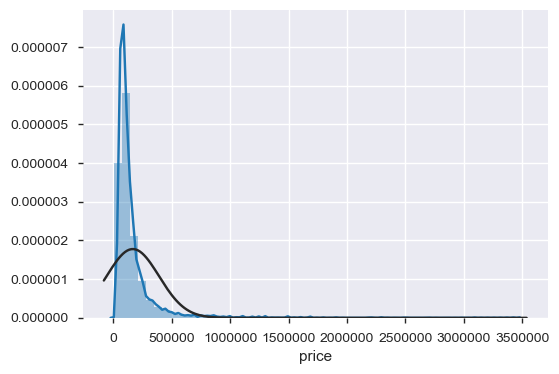

In [10]:
# Distribución inicial de 'price'
plt.figure(figsize=(6,4))
sns.distplot(datos['price'],fit=norm);

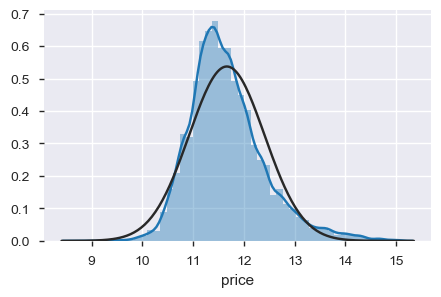

In [11]:
# Distribución con transformación con log1p de 'price'
plt.figure(figsize=(5,3))
sns.distplot(np.log1p(datos['price']),fit=norm);

##### El vector objetivo (price) se concentra en valores bajos, se transformará con log1p para acercarlo a una distribución normal.

### Análisis de variable continua (surface_total).

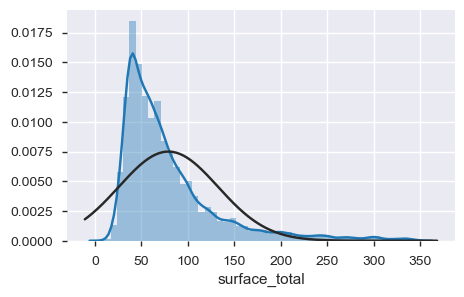

In [12]:
# Distribución inicial de 'surface_total'
plt.figure(figsize=(5,3))
sns.distplot(datos['surface_total'],fit=norm);

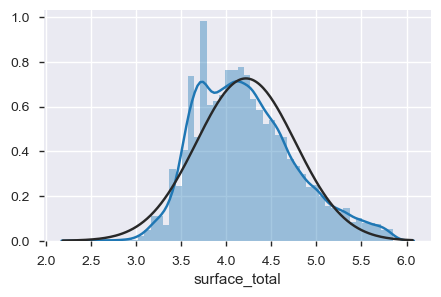

In [13]:
# Distribución con transformación con log1p de 'surface_total'
plt.figure(figsize=(5,3))
sns.distplot(np.log1p(datos['surface_total']),fit=norm);

##### Al igual que el vector objetivo, la variable surface_total se concentra en valores bajos, se transformará con log1p para acercarlo a una distribución normal.

### Análisis datos perdidos.

In [14]:
datos.isna().sum()

Id                        0
pais                      0
provincia_departamento    0
ciudad                    0
property_type             0
operation_type            0
rooms                     0
bedrooms                  0
bathrooms                 0
surface_total             0
currency                  0
price                     0
dtype: int64

##### No hay valores perdidos en el dataset de entrenamiento.

In [15]:
predice.isna().sum()

Id                        0
pais                      0
provincia_departamento    0
ciudad                    0
property_type             0
operation_type            0
rooms                     0
bedrooms                  0
bathrooms                 0
surface_total             0
currency                  0
dtype: int64

##### No hay valores perdidos en el dataset para predicción.

### Análisis outliers.

Para la identificación y eliminación de outliers se transformará el vector ojetivo (price) y el atributo surface_total con log1p.

La identificación se realizará en forma visual, usando gráfico de log_price versus log_surface_total y se eliminarán los puntos que se encuentren en la zona superior izquierda (bajo log_surface_total y alto log_price), inferior derecha (alto log_surface_total y bajo log:price) y zona media de log_surface_total con alto/bajo log_price.

In [16]:
datos['log_price']=np.log1p(datos['price'])
datos['log_surface']=np.log1p(datos['surface_total'])
datos=datos.drop(columns= ['price','surface_total'])

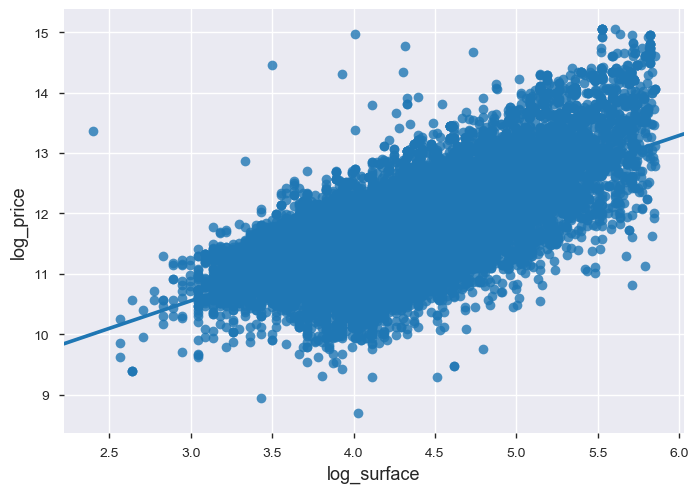

In [17]:
sns.regplot(data=datos, x='log_surface', y='log_price')
plt.ylabel('log_price', fontsize=13)
plt.xlabel('log_surface', fontsize=13)
plt.show()

In [18]:
datos = datos.drop(datos[(datos['log_price'] > 13) & (datos['log_surface'] < 3.7)].index)
datos = datos.drop(datos[(datos['log_price'] > 14.2) & (datos['log_surface'] < 4.5)].index)
datos = datos.drop(datos[(datos['log_price'] < 9)].index)
datos = datos.drop(datos[(datos['log_price'] < 11.3) & (datos['log_surface'] > 5.6)].index)

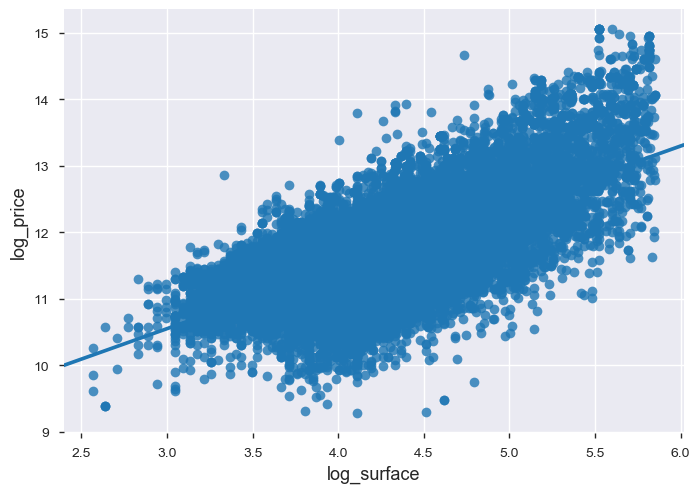

In [19]:
sns.regplot(data=datos, x='log_surface', y='log_price')
plt.ylabel('log_price', fontsize=13)
plt.xlabel('log_surface', fontsize=13)
plt.show()

In [20]:
datos=datos.reset_index(drop=True)

In [21]:
len(datos)

25649

### Análisis de variables categóricas con gran cantidad de valores distintos (ciudad y provincia_departamento).

#### Analisis datos atributo 'ciudad'.

In [22]:
ciudad_datos=datos['ciudad'].to_list()

In [23]:
ciudad_pred=predice['ciudad'].to_list()

In [24]:
# Ciudades que están en dataset de entrenamiento y no están en dataset de predicción.
ciudad_dif1=list(set(ciudad_datos) - set(ciudad_pred))

In [25]:
len(ciudad_dif1)

71

#### Analisis datos atributo 'provincia_departamento'.

In [26]:
prov_datos=datos['provincia_departamento'].to_list()

In [27]:
prov_pred=predice['provincia_departamento'].to_list()

In [28]:
# Provincia/Departamento que están en dataset de entrenamiento y no están en dataset de predicción.
prov_dif1=list(set(prov_datos) - set(prov_pred))

In [29]:
len(prov_dif1)

8

In [30]:
prov_dif1

['Jujuy', 'Boyacá', 'Meta', 'Chaco', 'Tucumán', 'Huila', 'Cauca', 'Chubut']

## 2. Preparacion datos.

### 2.1 Preparación datos de entrenamiento.

In [31]:
# Eliminación de atributos con valor único o carácter no predictivo (Id)
datos=datos.drop(columns=['Id','property_type','operation_type', 'currency'])

### Filtrar observaciones para hacer coincidir variables categóricas entre dataframes.

In [32]:
for i in prov_dif1:
    datos = datos.drop(datos[(datos['provincia_departamento'] == i)].index)

In [33]:
for j in ciudad_dif1:
    datos = datos.drop(datos[(datos['ciudad'] == j)].index)

In [34]:
datos=datos.reset_index(drop=True)

In [35]:
datos.rename(columns={'provincia_departamento': 'prov_depto'}, inplace=True)

### Binarización de variables categóricas.

In [36]:
col_obj=[]
col_num=[]
for colnames, serie in datos.iteritems():
    if serie.dtype == 'object':
        col_obj.append(colnames)
    else:
        col_num.append(colnames)
df_obj=datos.loc[:,col_obj]
df_num=datos.loc[:,col_num]

In [37]:
df_obj.head()

,pais,prov_depto,ciudad
0,Argentina,Capital Federal,Villa Crespo
1,Argentina,Capital Federal,Palermo
2,Colombia,Atlántico,Barranquilla
3,Colombia,Valle del Cauca,Cali
4,Argentina,Capital Federal,Balvanera


In [38]:
df_obj['pais'].value_counts()[:1]

Argentina    16772
Name: pais, dtype: int64

In [39]:
df_obj['prov_depto'].value_counts()[:1]

Capital Federal    8959
Name: prov_depto, dtype: int64

In [40]:
df_obj['ciudad'].value_counts()[:1]

Bogotá D.C    3129
Name: ciudad, dtype: int64

In [41]:
datos_binarios=pd.get_dummies(datos, prefix=col_obj)

In [42]:
mayoritarias=['pais_Argentina', 'prov_depto_Capital Federal', 'ciudad_Bogotá D.C']

In [43]:
df_modelos=datos_binarios.drop(columns=mayoritarias)

### Eliminación de atributos con alta correlación.

In [44]:
def identifica_alta_correlacion(df, threshold=.8):
    """
    identifica_alta_correlcion: Genera un reporte sobre las correlaciones existentes entre variables,
    condicional a un nivel arbitrario.

    Parámetros de ingreso:
        - df: un objeto pd.DataFrame, por lo general es la base de datos a trabajar.
        - threshold: Nivel de correlaciones a considerar como altas. Por defecto es .8.

    Retorno:
        - Un pd.DataFrame con los nombres de las variables y sus correlaciones
    """

    # extraemos la matriz de correlación con una máscara booleana
    tmp = df.corr().mask(abs(df.corr()) < threshold, df)
    # convertimos a long format
    tmp = pd.melt(tmp)
    # agregamos una columna extra que nos facilitará los cruces entre variables
    tmp['var2'] = list(df.columns) * len(df.columns)
    # reordenamos
    tmp = tmp[['variable', 'var2', 'value']].dropna()
    # eliminamos valores duplicados
    tmp = tmp[tmp['value'].duplicated()]
    # eliminamos variables con valores de 1 
    tmp=tmp[tmp['value'] < 1.00]
    return tmp.sort_values(by='value', ascending='False')

In [45]:
# Análisis correlación entre variables del vector de atributos.
identifica_alta_correlacion(df_modelos, threshold=.9)

,variable,var2,value
10378,ciudad_Bucaramanga,prov_depto_Santander,0.901467
23817,ciudad_Mar del Plata,prov_depto_Buenos Aires Costa Atlántica,0.933487
32319,ciudad_Rosario,prov_depto_Santa Fe,0.966509
18866,ciudad_Ibagué,prov_depto_Tolima,0.970123
11208,ciudad_Cali,prov_depto_Valle del Cauca,0.978424
8908,ciudad_Barranquilla,prov_depto_Atlántico,0.983136
29624,ciudad_Pereira,prov_depto_Risaralda,0.989958


In [46]:
# Elimina atributos con alta correlación.
df_alta=identifica_alta_correlacion(df_modelos, threshold=.9)
lista_alta=df_alta['variable']
df_modelos=df_modelos.drop(columns=lista_alta)

### 2.2 Preparación datos para predicción.

Para la preparación de este dataset se realizarán los ajustes requeridos para que tenga las mismas columnas que se encuentran en el dataset de entrenamiento.

In [47]:
id_predice=predice['Id']
predice['log_surface']=np.log1p(predice['surface_total'])
predice=predice.drop(columns= ['surface_total'])
predice=predice.drop(columns=['Id','property_type','operation_type', 'currency'])
predice.rename(columns={'provincia_departamento': 'prov_depto'}, inplace=True)

In [48]:
col_obj=[]
col_num=[]
for colnames, serie in predice.iteritems():
    if serie.dtype == 'object':
        col_obj.append(colnames)
    else:
        col_num.append(colnames)
df_obj_pred=predice.loc[:,col_obj]
df_num_pred=predice.loc[:,col_num]

In [49]:
df_obj_pred.head()

,pais,prov_depto,ciudad
0,Argentina,Santa Fe,Rosario
1,Argentina,Capital Federal,Villa Urquiza
2,Argentina,Capital Federal,Almagro
3,Colombia,Cundinamarca,Mosquera
4,Argentina,Buenos Aires Costa Atlántica,Mar del Plata


In [50]:
df_obj_pred['pais'].value_counts()[:1]

Argentina    4250
Name: pais, dtype: int64

In [51]:
df_obj_pred['prov_depto'].value_counts()[:1]

Capital Federal    2290
Name: prov_depto, dtype: int64

In [52]:
df_obj_pred['ciudad'].value_counts()[:1]

Bogotá D.C    766
Name: ciudad, dtype: int64

In [53]:
# Binarización variables categóricas
predice_binarios=pd.get_dummies(predice, prefix=col_obj)

In [54]:
df_predicciones=predice_binarios.drop(columns=mayoritarias)

In [55]:
columnas_pred=df_predicciones.columns
columnas_modelo=df_modelos.columns

In [56]:
columnas_dif=list(set(columnas_pred) - set(columnas_modelo))

In [57]:
columnas_dif

['ciudad_Zapala',
 'ciudad_Catalinas',
 'ciudad_Costa Azul',
 'ciudad_La Lucila del Mar',
 'ciudad_Corrientes',
 'ciudad_Barranquilla',
 'prov_depto_Corrientes',
 'ciudad_Mar del Plata',
 'ciudad_Sopetrán',
 'ciudad_Caldas',
 'ciudad_Facatativá',
 'ciudad_Bucaramanga',
 'ciudad_Florencio Varela',
 'ciudad_Rosario',
 'ciudad_Pereira',
 'ciudad_Cali',
 'ciudad_Ibagué',
 'prov_depto_San Luis']

In [58]:
df_predicciones=df_predicciones.drop(columns=columnas_dif)

## 3. Entrenamiento y calibración modelos.

Para la búsqueda del modelo con mejor desempeño, se entrenarán los siguientes modelos, en su versión para regresión:

- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM

### 3.1 Entrenamiento inicial modelos. 

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error, make_scorer

In [60]:
y= df_modelos.loc[:,['log_price']]
X= df_modelos.drop(columns=['log_price'])
n = .2
seed = 9605

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n, random_state=seed)

scorer = make_scorer(mean_squared_log_error, greater_is_better = False)

In [61]:
# Función para comparar desempeño entre modelos

def compara_modelos(estimators, X_tr, y_tr, X_te, y_te):
    tmp_names=[]
    score_train, score_test=[],[]
    for index, value in enumerate(estimators):
        tmp_names.append(value[0])
        estimator_fit = value[1].fit(X_tr, y_tr)
    
        # RMSLE
        pred_train= estimator_fit.predict(X_tr)
        pred_test= estimator_fit.predict(X_te)
        rmsle_train=np.sqrt(mean_squared_log_error(np.expm1(y_tr), np.expm1(pred_train)))
        score_train.append(rmsle_train)
        rmsle_test=np.sqrt(mean_squared_log_error(np.expm1(y_te), np.expm1(pred_test)))
        score_test.append(rmsle_test)
    rmsle_dataframe = pd.DataFrame( {'Modelos': tmp_names, 'RMSLE-Train': score_train,'RMSLE-Test': score_test})
    return rmsle_dataframe.sort_values(by='RMSLE-Test')

In [62]:
# Modelos iniciales.
mod_rf = RandomForestRegressor(random_state=seed)
mod_gb = GradientBoostingRegressor(random_state=seed)
mod_xgb = XGBRegressor(seed=9605)
mod_lgb = lgb.LGBMRegressor(objective='regression', random_state=seed)

In [63]:
# Grilla de estimadores (modelos)
estimators_base = [('Random Forest', mod_rf),
                   ('Gradient Boosting', mod_gb),
                   ('Xgboost', mod_xgb),
                   ('LGBM', mod_lgb)]

In [64]:
compara_modelos(estimators_base, X_train, y_train.values.ravel(), X_test, y_test)

,Modelos,RMSLE-Train,RMSLE-Test
3,LGBM,0.249436,0.255439
0,Random Forest,0.165621,0.260514
1,Gradient Boosting,0.287711,0.288951
2,Xgboost,0.288012,0.289389


### 3.2 Calibración modelos.

#### Calibración Random Forest.

In [65]:
# Creamos grilla con hiperparámetros
param_rf = {"n_estimators": [125, 250, 350],
            "min_samples_split": [2, 4, 6],
            "max_features": ["sqrt", "log2", None]}

# Generamos nuestro modelo
mod_rf = RandomForestRegressor(random_state=seed)

In [66]:
%%time
mod_rf_gcv = GridSearchCV(mod_rf, param_grid=param_rf, scoring=scorer, cv=3, n_jobs=-1).fit(X_train, y_train.values.ravel())

Wall time: 21min 56s


In [67]:
print("Parámetros primera grilla Random Forest: ", mod_rf_gcv.best_params_)

Parámetros primera grilla Random Forest:  {'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 350}


In [68]:
# Haciendo fine tuning se obtiene el siguiente modelo calibrado
rf_best = RandomForestRegressor(max_features='sqrt', min_samples_split = 5, n_estimators = 330, random_state=seed)

#### Calibración Gradient Boosting.

In [69]:
# Creamos grilla con hiperparámetros
param_gb = {"n_estimators": [150, 250, 500, 700, 1000],
            "learning_rate": [0.05, 0.07, 0.12, 0.15],
            "subsample": [0.7, 0.8, 0.9]}

# Generamos nuestro modelo
mod_gb = GradientBoostingRegressor(random_state=seed)

In [70]:
%%time
mod_gb_gcv = GridSearchCV(mod_gb, param_grid=param_gb, scoring=scorer, cv=3, n_jobs=-1).fit(X_train, y_train.values.ravel())

Wall time: 44min 30s


In [71]:
print("Parámetros primera grilla Gradient Boosting: ", mod_gb_gcv.best_params_)

Parámetros primera grilla Gradient Boosting:  {'learning_rate': 0.15, 'n_estimators': 700, 'subsample': 0.8}


In [72]:
# Haciendo fine tuning se obtiene el siguiente modelo calibrado
gb_best = GradientBoostingRegressor(n_estimators= 1000, learning_rate= 0.15, subsample= 0.9, random_state=seed)

#### Calibración XGBoost.

In [73]:
# Creamos primera grilla con hiperparámetros
param1_xgb = {"learning_rate": [0.03, 0.05, 0.07],
              "n_estimators": [150, 250, 350],                        
              "subsample": [0.7, 0.8, 0.9]}

# Generamos nuestro modelo
mod1_xgb = XGBRegressor(seed=9605)

In [74]:
%%time
mod1_xgb_gcv = GridSearchCV(mod1_xgb, param_grid=param1_xgb, scoring=scorer, cv=3, n_jobs=-1).fit(X_train, y_train.values.ravel())

Wall time: 11min 7s


In [75]:
print("Parámetros primera grilla XGBoost: ", mod1_xgb_gcv.best_params_)

Parámetros primera grilla XGBoost:  {'learning_rate': 0.07, 'n_estimators': 350, 'subsample': 0.7}


In [76]:
# Creamos segunda grilla con hiperparámetros
param2_xgb = {"colsample_bytree": [0.6, 0.7, 0.8],
              "max_depth": [6, 8, 10],
              "reg_lambda": [0.6, 0.8, 1.0]}

# Generamos nuestro modelo
mod2_xgb = XGBRegressor(learning_rate= 0.07, n_estimators= 350, subsample= 0.7, seed=9605)

In [77]:
%%time
mod2_xgb_gcv = GridSearchCV(mod2_xgb, param_grid=param2_xgb, scoring=scorer, cv=3, n_jobs=-1).fit(X_train, y_train.values.ravel())

Wall time: 39min 53s


In [78]:
print("Parámetros segunda grilla XGBoost: ", mod2_xgb_gcv.best_params_)

Parámetros segunda grilla XGBoost:  {'colsample_bytree': 0.6, 'max_depth': 10, 'reg_lambda': 0.8}


In [79]:
# Haciendo fine tuning se obtiene el siguiente modelo calibrado
xgb_best = XGBRegressor(colsample_bytree=0.695, learning_rate=0.07, max_depth=10, n_estimators=267, reg_lambda=0.8, subsample=0.9, seed=9605)

#### Calibración LightGBM.

In [80]:
# Creamos grilla con hiperparámetros
param_lgb = {"n_estimators": [250, 350, 450, 550, 750],                        
             "reg_lambda": [0.1, 0.2, 0.4, 0.5]}

# Generamos nuestro modelo
mod_lgb = lgb.LGBMRegressor(objective='regression', random_state=seed)

In [81]:
%%time
mod_lgb_gcv = GridSearchCV(mod_lgb, param_grid=param_lgb, scoring=scorer, cv=3, n_jobs=-1).fit(X_train,y_train.values.ravel())

Wall time: 1min 25s


In [82]:
print("Parámetros primera grilla LightGBM: ", mod_lgb_gcv.best_params_)

Parámetros primera grilla LightGBM:  {'n_estimators': 550, 'reg_lambda': 0.2}


In [83]:
# Modelo calibrado LightGBM
lgb_best = lgb.LGBMRegressor(objective='regression', n_estimators=550, reg_alpha=0.2, random_state=seed)

#### Desempeño modelos calibrados.

In [84]:
estimators_best = [('Ramdom Forest', rf_best),
                   ('Gradient Boosting', gb_best),
                   ('Xgboost', xgb_best),
                   ('LGBM', lgb_best)]

In [85]:
compara_modelos(estimators_best, X_train, y_train.values.ravel(), X_test, y_test)

,Modelos,RMSLE-Train,RMSLE-Test
2,Xgboost,0.214303,0.244983
3,LGBM,0.228008,0.249552
0,Ramdom Forest,0.182853,0.250222
1,Gradient Boosting,0.229189,0.250319


El mejor modelo calibrado es XGBoost con un RMSLE en Test de 0.244983.

## 4. Entrenamiento con VotingRegressor y calibración.

In [86]:
from sklearn.ensemble import VotingRegressor

In [87]:
estimators1 = [('Ramdom Forest', rf_best),
              ('Gradient Boosting', gb_best),
              ('Xgboost', xgb_best), 
              ('LGBM', lgb_best)]

estimators2 = [('Random Forest', rf_best),
              ('Xgboost', xgb_best),             
              ('Gradient Boosting', gb_best)]

estimators3 = [('Random Forest', rf_best),
               ('Xgboost', xgb_best),
               ('LGBM', lgb_best)]

estimators4 = [('Random Forest', rf_best),
              ('Gradient Boosting', gb_best),
              ('LGBM', lgb_best)]

estimators5 = [('Gradient Boosting', gb_best),
               ('Xgboost', xgb_best),
               ('LGBM', lgb_best)]

In [88]:
estimators_regressor =[('Modelo 1', VotingRegressor(estimators1)),
                       ('Modelo 2', VotingRegressor(estimators2)),
                       ('Modelo 3', VotingRegressor(estimators3)),
                       ('Modelo 4', VotingRegressor(estimators4)),
                       ('Modelo 5', VotingRegressor(estimators5))]

#### Desempeño modelos con VotingRegressor.

In [89]:
compara_modelos(estimators_regressor, X_train, y_train.values.ravel(), X_test, y_test)

,Modelos,RMSLE-Train,RMSLE-Test
1,Modelo 2,0.202338,0.241452
0,Modelo 1,0.206869,0.241523
3,Modelo 4,0.205791,0.241735
2,Modelo 3,0.202042,0.241777
4,Modelo 5,0.220177,0.244386


VotingRegressor con 3 modelos (Random Forest, XGBoost y Gradient Boosting) tiene el mejor desempeño, logrando un RMSLE de 0.241452, que es una mejora respecto a 0.244983 (XGBoost calibrado). 

#### Calibración VotingRegressor.

In [90]:
estimators_tuning =[('Modelo 433', VotingRegressor(estimators2, weights=[.4, .3, .3])),
                    ('Modelo 343', VotingRegressor(estimators2, weights=[.3, .4, .3])),
                    ('Modelo 334', VotingRegressor(estimators2, weights=[.3, .3, .4]))]

In [91]:
compara_modelos(estimators_tuning, X_train, y_train.values.ravel(), X_test, y_test)

,Modelos,RMSLE-Train,RMSLE-Test
0,Modelo 433,0.199332,0.241292
1,Modelo 343,0.203287,0.241531
2,Modelo 334,0.204581,0.241749


In [92]:
estimators_fine_tuning =[('Modelo 1', VotingRegressor(estimators2, weights=[.36, .32, .32])),
                         ('Modelo 2', VotingRegressor(estimators2, weights=[.38, .31, .31])),
                         ('Modelo 3', VotingRegressor(estimators2, weights=[.42, .29, .29])),
                         ('Modelo 4', VotingRegressor(estimators2, weights=[.44, .28, .28]))]

In [93]:
compara_modelos(estimators_fine_tuning, X_train, y_train.values.ravel(), X_test, y_test)

,Modelos,RMSLE-Train,RMSLE-Test
2,Modelo 3,0.198471,0.241290
3,Modelo 4,0.197630,0.241308
1,Modelo 2,0.200212,0.241316
0,Modelo 1,0.201111,0.241360


El modelo con mejor desempeño es VotingRegressor con 3 modelos (Random Forest, XGBoost y Gradient Boosting) y weights=[.42, .29, .29]

## 5. Predicciones y Submission.

In [94]:
# Entrenamos el modelo con mejor desempeño con el dataset completo del train
voting_regressor_final = VotingRegressor(estimators2, weights=[.42, .29, .29]).fit(X,y)

# Ordenamos las columnas del dataset para predicciones según las columnas del train
df_predicciones=df_predicciones[X_train.columns]

# Realizamos predicciones (usamos función inversa de log1p (expm1))
predicciones = np.expm1(voting_regressor_final.predict(df_predicciones))

# Dataframe entrega
entrega=pd.DataFrame({'id':id_predice , 'price': predicciones.flatten()}).set_index('id')

# CSV entrega
entrega.to_csv('Submission_final.csv')